# Project - Titanic Classification
Author: Drew Burritt


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We are going to follow the following workflow: Split data into training and test set. Use the training portion to find the best model (optionally using grid search) and cross-validation. Evaluate the *winner* on the test set.

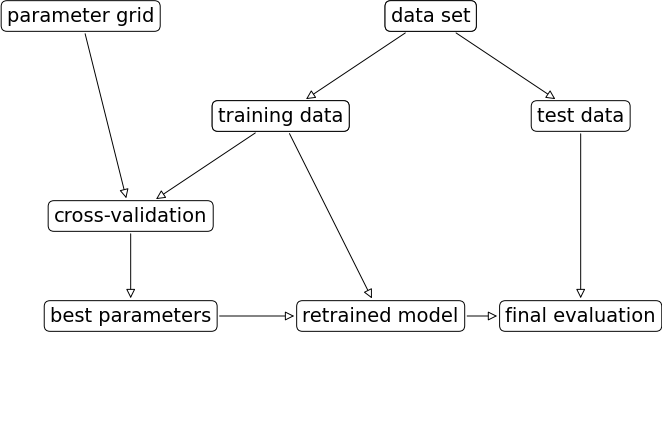

In [4]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## 0. Function definitions

In [5]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation scores of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    model.fit(X,y)
    scores = cross_validate(model,X,y,cv= cv, scoring=scoring, return_train_score=True) 
    return (scores['train_score'].mean()) , (scores['test_score'].mean())

     #TODO: implement function body
    

In [6]:
# OPTIONAL METHOD
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.
    
        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        - cross-validation validation score 
        
        scores are printed with 3 decimal places.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        returns: None
        
    '''
    print(grid_search.best_params_)
    print( "Training score: {:.3f};".format(grid_search.cv_results_['mean_train_score'][grid_search.best_index_]), "Validation Score: {:.3f}".format(grid_search.best_score_))
    #print(grid_search.best_score_))
    #TODO: implement function body
    

In [7]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [8]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    
    #TODO: implement function body
    
    #mat = confusion_matrix(y_test_enc, y2_pred_enc, labels=labels)
    mat = confusion_matrix(y_actual, y_pred, labels=labels)



    sns.heatmap(mat, xticklabels=labels,  yticklabels=labels, square=True, annot=True, cbar=False,fmt='d')
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.title(title)

## 1. Load data

### 1.1 Prepare the feature train and test df
Using train/test.csv, load the titanic data set

In [9]:
# TODO: add data loading code
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
y_train = train_df['Survived']
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 2. Inspect the data 

### 2.1 Relationship between features and target classes
As shown below the training dataset has 891 datapoints. The a histplot() was used to show the relationship for the ages of surviors, for both men and women. As well as the count plots for Pclass, Sex, Parch, SibSp, Embarked.
From the histplots it can be seen that the highest number of male survivors was between the ages of 18-30. While for women, the ranges is wider with most surviors being between 12 and 40. For both male and female there is also a in both graphs for infants. The count plots show that for class 1 and 2 about half of them survived, however in third class only about 35% survied. For sex, about 20% of men survived, while about 60% of women survived.

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [36]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Text(0.5, 1.0, 'Male')

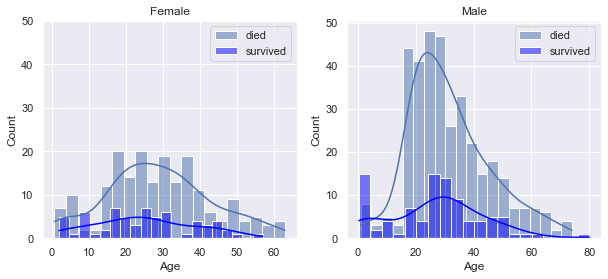

In [43]:
women_survived = train_df[(train_df.Sex == 'female') & (train_df.Survived == 0)]
women_died = train_df[(train_df.Sex == 'female') & (train_df.Survived == 1)]
men_survived = train_df[(train_df.Sex == 'male') & (train_df.Survived == 1)]
men_died = train_df[(train_df.Sex == 'male') & (train_df.Survived == 0)]

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
ax = sns.histplot(women_died.Age.dropna(), bins=20, label = 'died', ax = axes[0], kde =True)
ax = sns.histplot(women_survived.Age.dropna(), bins=20, label = 'survived', ax = axes[0], kde =True, color = 'blue')
ax.legend()
ax.set_title('Female')
ax. set(ylim=(0, 50))
ax = sns.histplot(men_died.Age.dropna(), bins=20, label = 'died', ax = axes[1], kde =True)
ax = sns.histplot(men_survived.Age.dropna(), bins=20, label = 'survived', ax = axes[1], kde =True, color = 'blue')
ax.legend()
ax.set_title('Male')


<Figure size 360x360 with 0 Axes>

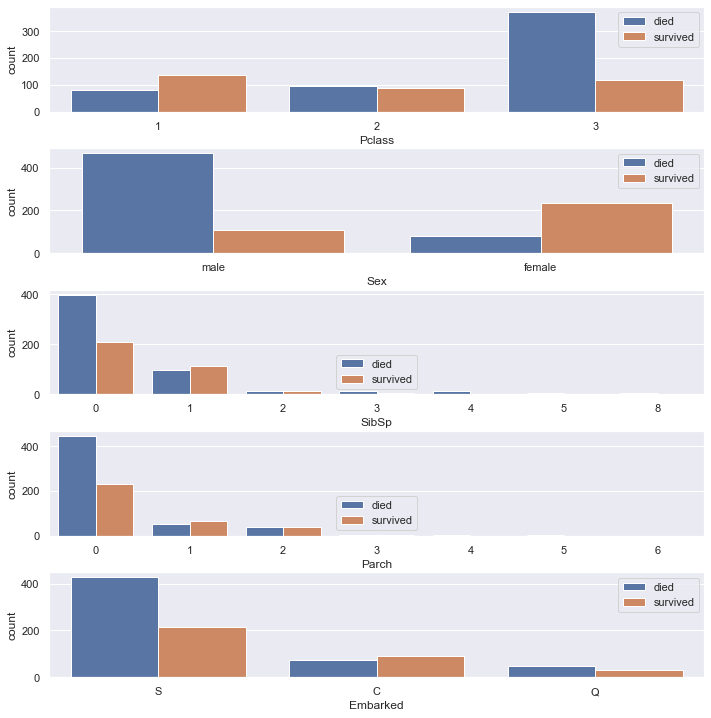

In [38]:
# TODO: add countplots for each feature.
label = ['died','survived']
fig = plt.figure(figsize=(5, 5))
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5)
fig.tight_layout()
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(x=train_df.loc[:,'Pclass'], hue=y_train,ax=ax1)
ax1.legend(label)
sns.countplot(x=train_df.loc[:,'Sex'], hue=y_train, ax=ax2)
ax2.legend(label)
sns.countplot(x=train_df.loc[:,'SibSp'], hue=y_train, ax=ax3)
ax3.legend(label)
sns.countplot(x=train_df.loc[:,'Parch'], hue=y_train, ax=ax4)
ax4.legend(label)
sns.countplot(x=train_df.loc[:,'Embarked'], hue=y_train, ax=ax5)
ax5.legend(label)


## 3. Preprocessing
As shown above, the cabin column only has data for about 20% of the rows, with so much missing I decided to drop this column. The name column was also dropped as the names are unique. PassengerID was also dropped as it is is just a row index. Ticket was also dropped as they are mostly unique values. The training data has some other missing values in Age and Embarked. Age is missing 177 of the 891 values, but as shown by the plots age is an important feature. To deal with this I filled all the missing values with the average age. For Embarked, only 2 values are missing, so they were filled with 'S', the most common value. In the test set, one of the values for Fare is missing, this was also filled with the mean value


In [15]:
combined = [train_df, test_df]
for dataset in combined: 
    #
    dataset["Age"].fillna(dataset.Age.mean(), inplace=True)
    dataset["Embarked"].fillna("S", inplace=True)
    dataset["Fare"].fillna(dataset.Fare.mean(), inplace=True)
    dataset.loc[:,'Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    dataset.loc[:,'Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
X_train = train_df[['Pclass', 'Sex', 'Age', 'Parch', 'SibSp', 'Fare', 'Embarked']]
X_test = test_df[['Pclass', 'Sex', 'Age', 'Parch', 'SibSp', 'Fare', 'Embarked']]


In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int32  
 2   Age       891 non-null    float64
 3   Parch     891 non-null    int64  
 4   SibSp     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 41.9 KB


## 5. Compare models using cross-validation
Create a list containing a `LogisticRegression()`, 
          `SVC()`,
          `BernoulliNB()`,
        `RandomForestClassifier(random_state=1)`, 
         `GradientBoostingClassifier(random_state=1)` objects.

Iterate this list, then:
- compute the **average accuracy** using `get_classifier_cv_score()` defined above, 
- rank the models based on validation **average score** (best first),
- and print the ranked models training and validation scores with **3 decimal places**. 

Use training data and 7-fold cross-validation.

In [106]:
# TODO: add cross-validation comparison here
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

results = {}
for model in [LogisticRegression(max_iter=1000,random_state=1), SVC(random_state=1),BernoulliNB() ,RandomForestClassifier(random_state=1),GradientBoostingClassifier(random_state=1) ]:
    results[model] =  [train, test] = get_classifier_cv_score(model,X_train, y_train,'accuracy',7)
results = sorted(results.items(), key=lambda x: x[1][1], reverse=True)

In [107]:
for result in results:
    print(result[0], "Training score: {:.3f}".format(result[1][0]),  "Validation score: {:.3f}".format(result[1][1]))

GradientBoostingClassifier(random_state=1) Training score: 0.900 Validation score: 0.831
RandomForestClassifier(random_state=1) Training score: 0.984 Validation score: 0.822
LogisticRegression(max_iter=1000, random_state=1) Training score: 0.803 Validation score: 0.794
BernoulliNB() Training score: 0.785 Validation score: 0.785
SVC(random_state=1) Training score: 0.682 Validation score: 0.671


## 6.Hyperparameter tuning using grid search 

The inital cross-validation above showed that both DecisionTree based models might have merit. 

Logistic regression might also perform well if properly tuned.

Next, hyperparameters are tuned using grid search.

### 6.1 Grid search for RandomForestClassifier 

Perform grid search using `GridSearchCV` for the `RandomForestClassifier(random_state=55)`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Using the following hyperparameters and values:
- `'n_estimators': [50, 100, 200 ,300]`
- `'max_depth': [5, 7, 9, 11]`


In [69]:
# TODO: Setup grid search for RandomForestClassifier(random_state=55)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier (random_state=1)
param = {'n_estimators': [50, 100, 200 ,300],
'max_depth':  [5, 7, 9, 11]}

grid = GridSearchCV(estimator, param, cv=7, scoring='accuracy',return_train_score=True,n_jobs=-1)

In [70]:
# TODO: perform the grid search by calling fit()
grid.fit(X_train,y_train)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9, 11],
                         'n_estimators': [50, 100, 200, 300]},
             return_train_score=True, scoring='accuracy')

In [71]:
# TODO: call print_grid_search_result() to print the results
print_grid_search_result(grid)

{'max_depth': 9, 'n_estimators': 200}
Training score: 0.933; Validation Score: 0.837


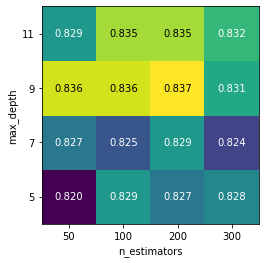

In [72]:
# TODO: call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid)

### 6.2 Gradient boosting classifier 
Perform grid search using `GridSearchCV` for the `GradientBoostingClassifier(max_depth=5, random_state=56)`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'n_estimators': [50, 100, 200, 300]`,
- `'learning_rate': [0.001, 0.01, 0.1, 1.0]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [75]:
# TODO: Setup grid search for GradientBoostingClassifier(max_depth=5, random_state=56)
from sklearn.model_selection import GridSearchCV

estimator = GradientBoostingClassifier (random_state=56)
param = {'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1, 1.0]}
grid = GridSearchCV(estimator, param, cv=7, scoring='accuracy',return_train_score=True,n_jobs=-1)

In [76]:
# TODO: perform the grid search by calling fit()
grid.fit(X_train,y_train)

GridSearchCV(cv=7, estimator=GradientBoostingClassifier(random_state=56),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200, 300]},
             return_train_score=True, scoring='accuracy')

In [77]:
# TODO: call print_grid_search_result() to print the results
print_grid_search_result(grid)

{'learning_rate': 0.1, 'n_estimators': 200}
Training score: 0.932; Validation Score: 0.834


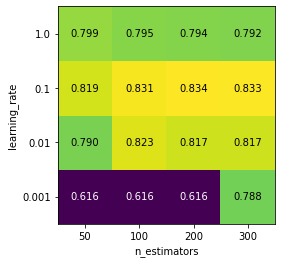

In [48]:
# TODO: call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid)

### 6.3 logistic Regression grid search
Perform grid search using `GridSearchCV` for the `LogisticRegression()`.

Grid search to use 7-fold cross-validation, and `accuracy` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'C': [0.0001, 0.001, 0.01, 0.1]`
- `'gamma': [0.1, 1, 10, 100]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [78]:
# TODO: Setup grid search for SVC()
from sklearn.model_selection import GridSearchCV

estimator = LogisticRegression(max_iter=1000, random_state =1)
param = {'C': [0.001, 0.01, 0.1, 10,100]}

grid = GridSearchCV(estimator, param, cv=7, scoring='accuracy',return_train_score=True,n_jobs=-1)

In [79]:
# TODO: perform the grid search by calling fit()
grid.fit(X_train,y_train)

GridSearchCV(cv=7, estimator=LogisticRegression(max_iter=1000, random_state=1),
             n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1, 10, 100]},
             return_train_score=True, scoring='accuracy')

In [80]:
# TODO: call print_grid_search_result() to print the results
print_grid_search_result(grid)


{'C': 0.1}
Training score: 0.811; Validation Score: 0.796


### *Question 2:* What are the training and validation scores of the three tuned (best) models? Summarize the results here.

For RandomForestClassifier()  
The best parameters are: max_depth': 9, 'n_estimators': 200  
resulting in training score= 0.933; validation score=0.837 

For GradientBoosingClassifier()  
The best parameters are: 'learning_rate': 0.1, 'n_estimators': 200  
resulting in training score= 0.932; validation score=0.834  

For LogisticRegression()  
The best parameters are: 'C': 0.1, 'gamma': 10  
resulting in training score= 0.811; validation score=0.796


From these results, RandomForestClassifier provides the best results with a validation score of 0.837

## 7. Retrain best model
Retrain the best `RandomForestClassifier()` from the grid search above on the training dataset.

In [105]:
#TDOD: Retrain gradient boosting classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=9, n_estimators=200)
model.fit(X_train,y_train)
print("Training: Accuracy: {:.2f}".format(model.score(X_train, y_train)))
#output.to_csv('submission.csv', index=False)

Training: Accuracy: 0.93


In [96]:
pred = model.predict(X_test)
#print(X_test_enc.isnull().sum())
#len(test_df['PassengerId'])
#len(pred)

In [97]:
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'].values, 'Survived': pred.astype(np.int32)})
submission.to_csv('submission.csv', index=False)

## 9. Evaluate on test data
As this a kaggle competition, they do not provide targets for the test data. The submission.csv was uploaded to Kaggle. This resulted in a score of 0.78708 

## 10. Conclusion

In conclusion, crossvalidation and grid search were used to get the best the model. This was RandomForestClassifier which had a training accuracy of 0.93. This model scored 0.78708 on Kaggle test data.  
Looking at other scores on kaggle, it is possible to score a 1 with this dataset. To obtain a better score it is likely more feature engineering has to be done. I did not use the cabin data as most were missing, but it is likely that something useful could be extracted from it. I also used the mean to fill in the missing values for age, a different approach could have been used to fill them. Other methods could be tried, such as filling random ages to based on the standard deviation. The name column also contains the persons title, this could also be considered when filling the ages. Title could also be added as a separate feature. Other features could be created such as grouping Age and Fare into groups with a range. 

## 11. Reflection
Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating while working on this assignment.

Its interesting applying the course material to a real world example and dealing with a real dataset that isn't perfect. Trying to determine which features to use and how to improve the performance.